In [1]:
import torch
import torch.nn as nn
import utils
import numpy as np
import torchvision.transforms.functional as TF
from torchvision import transforms
import models
from PIL import Image
import cv2
import matplotlib.pyplot as plt
import math
from utils import to_pixel_samples
from utils import make_coord
import argparse
import random
model_spec = torch.load("save/ssrtr-lte_2024-04-13/epoch-last.pth")['model']
net = models.make(model_spec, load_sd=True).cuda()
print(net)
# utils.load_checkpoint(net,'checkpoints\Deraining\models\deraindrop-best-03-16-2346-it2\model_latest.pth')

c:\ProgramData\anaconda3\envs\torch\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


NAFLTEOURS(
  (encoder): SwinIR(
    (conv_first): Conv2d(3, 96, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (patch_embed): PatchEmbed(
      (norm): LayerNorm((96,), eps=1e-05, elementwise_affine=True)
    )
    (patch_unembed): PatchUnEmbed()
    (pos_drop): Dropout(p=0.0, inplace=False)
    (softmax): Softmax(dim=-1)
    (layers): ModuleList(
      (0): RSTB(
        (residual_group): BasicLayer(
          dim=96, input_resolution=(48, 48), depth=6
          (blocks): ModuleList(
            (0): SwinTransformerBlock(
              dim=96, input_resolution=(48, 48), num_heads=6, window_size=8, shift_size=0, mlp_ratio=4.0
              (norm1): LayerNorm((96,), eps=1e-05, elementwise_affine=True)
              (attn): WindowAttention(
                dim=96, window_size=(8, 8), num_heads=6
                (qkv): Linear(in_features=96, out_features=288, bias=True)
                (attn_drop): Dropout(p=0.0, inplace=False)
                (proj): Linear(in_features=96, out_f

In [2]:
features_in_hook = []
features_out_hook = []

def hook(module, fea_in, fea_out):
    features_in_hook.append(fea_in)
    features_out_hook.append(fea_out)

layer_name = 'encoder'
for (name, module) in net.named_modules():
    if name == layer_name:
        module.register_forward_hook(hook=hook)

print(features_in_hook) 
print(features_out_hook)

[]
[]


In [3]:
def resize_fn(img, size):
    return transforms.ToTensor()(
        transforms.Resize(size, Image.BICUBIC)(
            transforms.ToPILImage()(img)))

In [4]:
# img_path_L = r"/media/yi/E/Research/Datasets/Flickr1024/Test/001_L.png"
# img_path_R = r"/media/yi/E/Research/Datasets/Flickr1024/Test/001_R.png"
img_path_L = r"E:\Research\Datasets\Flickr1024\Test\001_L.png"
img_path_R = r"E:\Research\Datasets\Flickr1024\Test\001_R.png"
# img_path = r"E:\Research\Datasets\Deraindrop\test\test_b\data\53_rain.jpg"
# img_path = r"E:\Research\Datasets\Deraindrop\test\test_a\data\11_rain.png"
input_L = TF.to_tensor(Image.open(img_path_L))
input_R = TF.to_tensor(Image.open(img_path_R))
s = 4
w_lr = 48
w_hr = round(w_lr * s)
x0 = random.randint(0, input_L.shape[-2] - w_hr)
y0 = random.randint(0, input_L.shape[-1] - w_hr)
cropl_hr = input_L[:, x0: x0 + w_hr, y0: y0 + w_hr]
cropl_lr = resize_fn(cropl_hr, w_lr)
cropr_hr = input_R[:, x0: x0 + w_hr, y0: y0 + w_hr]
cropr_lr = resize_fn(cropr_hr, w_lr)

hr_coord, hrl_rgb = to_pixel_samples(cropl_hr.contiguous())
cell = torch.ones_like(hr_coord)
cell[:, 0] *= 2 / cropl_hr.shape[-2]
cell[:, 1] *= 2 / cropl_hr.shape[-1]
cropl_lr = cropl_lr.unsqueeze(0).cuda()
cropr_lr = cropr_lr.unsqueeze(0).cuda()
cell = cell.unsqueeze(0).cuda()
hr_coord = hr_coord.unsqueeze(0).cuda()

C:\Users\Administrator\AppData\Local\Temp\ipykernel_26080\46528700.py:3: DeprecationWarning: BICUBIC is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.BICUBIC instead.
  transforms.Resize(size, Image.BICUBIC)(


In [5]:
# input = torch.randn(16,3,224,224)
output = net(cropl_lr,cropr_lr,hr_coord,cell)
print(features_out_hook[0])
out = features_out_hook[0]

(tensor([[[[ 1.2261e-01,  8.1095e-02,  8.3308e-02,  ..., -1.5699e-02,
            4.3663e-02,  8.6219e-02],
          [ 6.1784e-02,  5.8228e-02,  7.0300e-02,  ..., -1.3802e-03,
            4.3577e-02, -2.2128e-03],
          [ 5.9190e-02,  4.8155e-02,  6.6436e-02,  ..., -1.5244e-02,
            3.0077e-03,  3.7601e-02],
          ...,
          [ 4.7716e-02,  3.7605e-02,  4.4717e-02,  ...,  3.4432e-02,
            8.5920e-02, -7.7871e-02],
          [ 3.8890e-02,  2.1006e-02,  4.7913e-02,  ...,  3.4443e-02,
            6.7515e-02, -1.0857e-01],
          [ 8.3659e-02,  9.7716e-02,  9.9201e-02,  ...,  1.0025e-01,
            7.5726e-02, -2.7586e-02]],

         [[-2.0781e-02,  7.0049e-03,  1.7438e-02,  ...,  7.1486e-03,
            1.8734e-02,  4.9314e-02],
          [-6.4934e-02,  9.2216e-03,  4.1365e-03,  ...,  9.8588e-03,
            4.5472e-02,  9.9812e-02],
          [-5.7491e-02,  1.7697e-02,  3.2556e-04,  ...,  4.7281e-02,
            4.2886e-02,  6.1365e-02],
          ...,
    

torch.Size([1, 48, 48, 48])


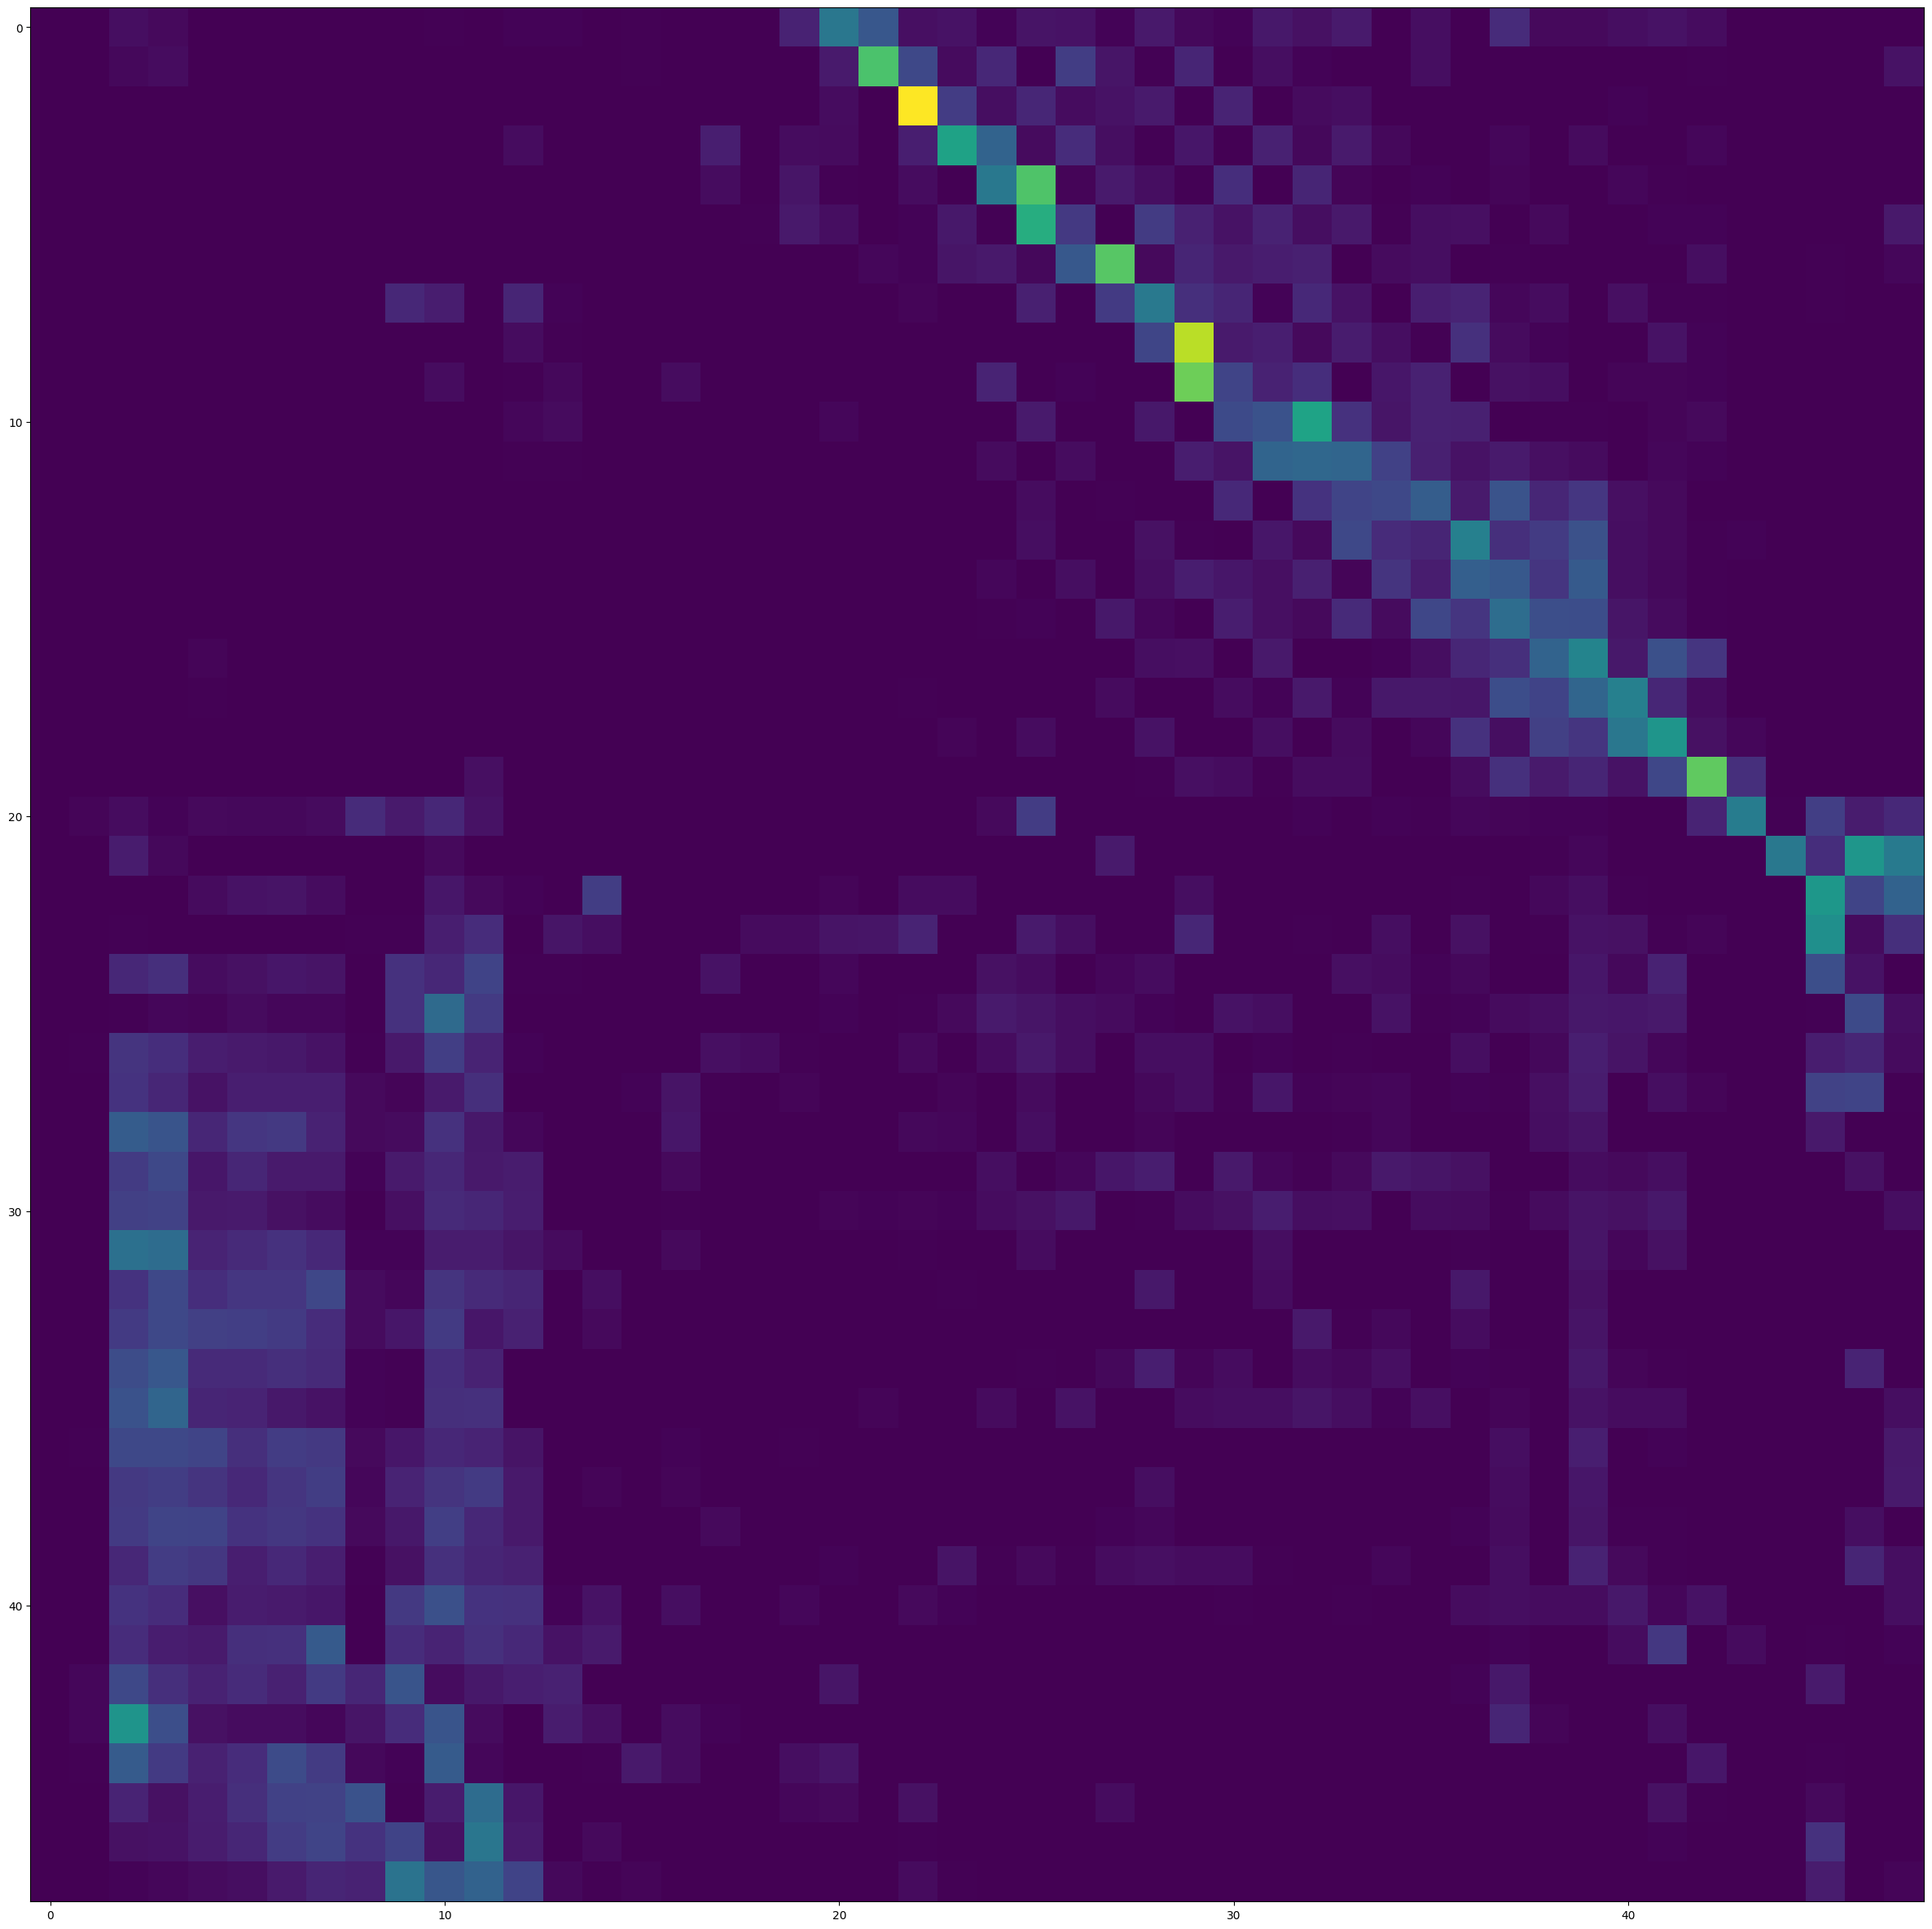

In [6]:
feat_left, feat_right, M_left_to_right, M_right_to_left = out
b,_,h,w = feat_left.shape
index = torch.arange(w).view(1, 1, 1, w).to(M_right_to_left.device).float()    # index: 1*1*1*w
disp1 = torch.sum(M_right_to_left * index, dim=-1).view(b, 1, h, w) # x axis of the corresponding point
disp2 = torch.sum(M_left_to_right * index, dim=-1).view(b, 1, h, w)
print(out[2].shape)
feat_left = feat_left.squeeze(0)
feat_right = feat_right.squeeze(0)
M_left_to_right = M_left_to_right.squeeze(0)
M_right_to_left = M_right_to_left.squeeze(0)
disp1 = disp1.squeeze(0)
disp2 = disp2.squeeze(0)
gray_scale = torch.sum(M_left_to_right,0)
gray_scale = gray_scale / M_left_to_right.shape[0]  # torch.Size([64, 112, 112]) —> torch.Size([112, 112])   从彩色图片变为黑白图片  压缩64个颜色通道维度，否则feature map太多张
gray_scale = gray_scale.data.cpu().numpy()


fig = plt.figure(figsize=(30, 50))
img_plot = plt.imshow(gray_scale)
# cv2.imwrite('heat_map.jpg', blended_img)  # 将图像保存到硬盘
plt.savefig('vis/attention_map.jpg', bbox_inches='tight')  # 若不加bbox_inches='tight'，保存的图片可能不完整

In [7]:
from sklearn.decomposition import PCA

# Reshape feat_right to 2D array
C,H,W = feat_right.shape
feat_right_2d = feat_right.cpu().detach().numpy().reshape(C, H*W).T

# Apply PCA
pca = PCA(n_components=3)
feat_right_pca = pca.fit_transform(feat_right_2d)

# Reshape feat_right_pca back to the original shape
feat_right_pca = feat_right_pca.reshape(H, W, 3)



Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


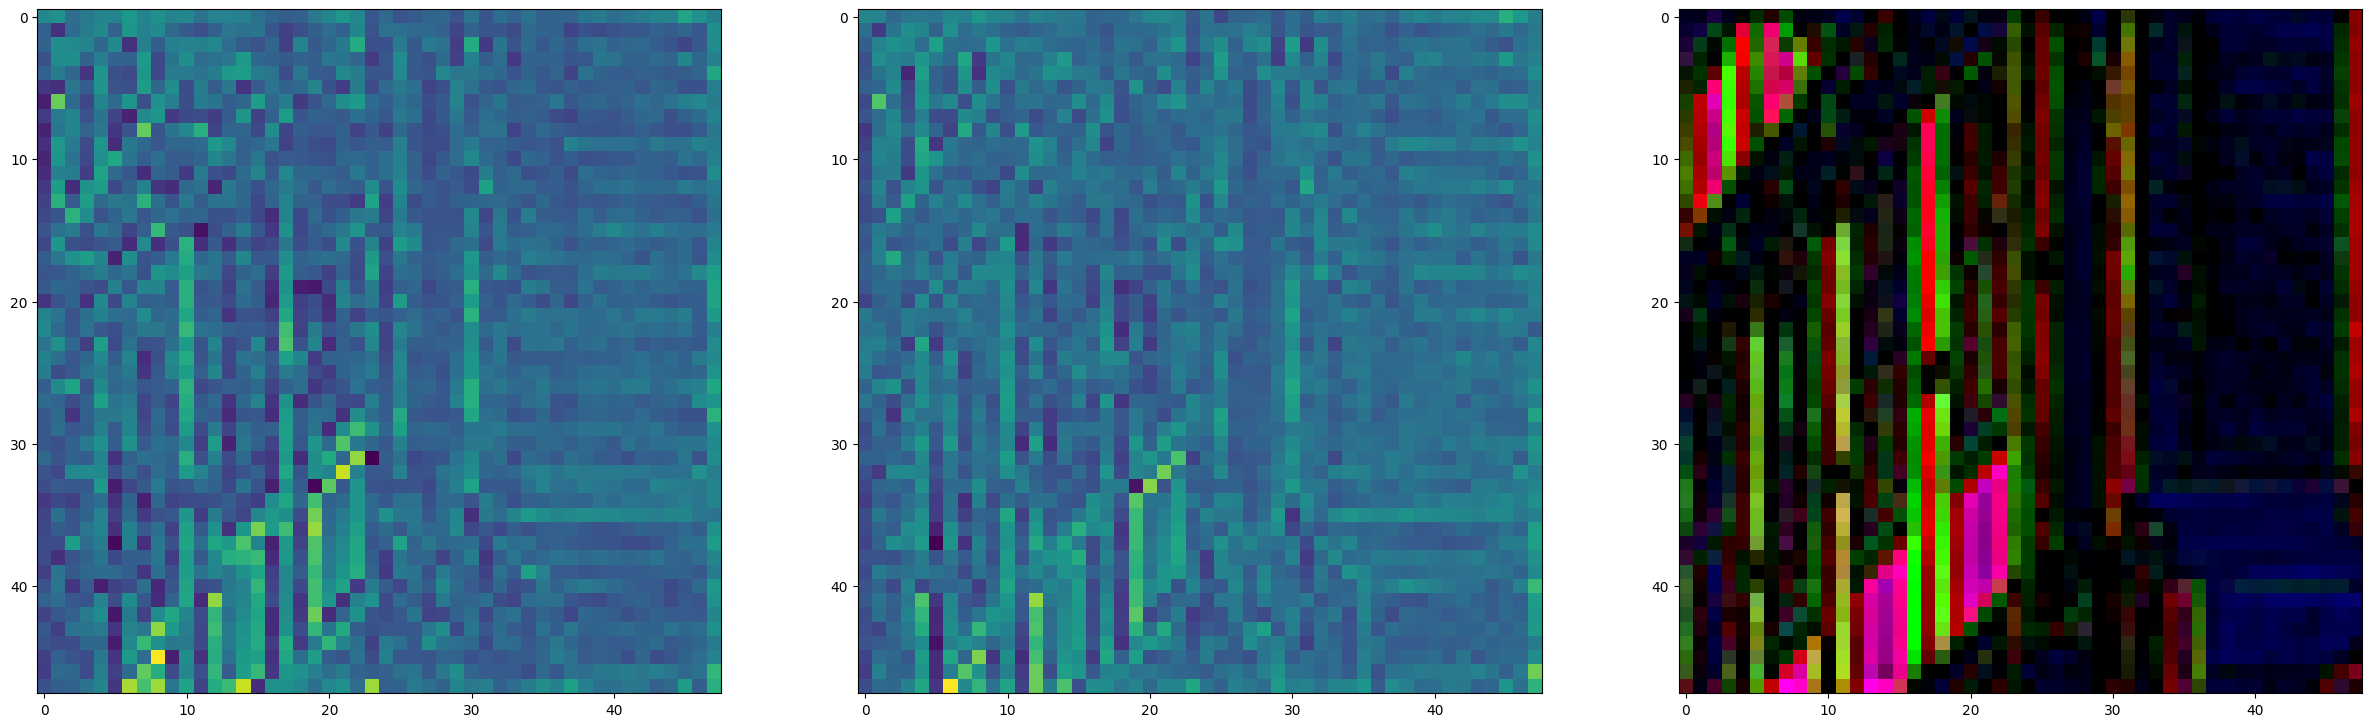

In [23]:
feat_leftW = torch.matmul(M_right_to_left, feat_right.permute(1,2,0)).permute(2,0,1)
feat_rightW = torch.matmul(M_left_to_right, feat_left.permute(1,2,0)).permute(2,0,1)

gray_scale = torch.sum(feat_rightW,0)
gray_scale = gray_scale / feat_left.shape[0]  # torch.Size([64, 112, 112]) —> torch.Size([112, 112])   从彩色图片变为黑白图片  压缩64个颜色通道维度，否则feature map太多张
gray_scale = gray_scale.data.cpu().numpy()

gray_scale2 = torch.sum(feat_right,0)
gray_scale2 = gray_scale2 / feat_left.shape[0]  # torch.Size([64, 112, 112]) —> torch.Size([112, 112])   从彩色图片变为黑白图片  压缩64个颜色通道维度，否则feature map太多张
gray_scale2 = gray_scale2.data.cpu().numpy()
gray_scale = gray_scale + gray_scale2

fig = plt.figure(1, figsize=(30, 50))
plt.subplot(1,3,1)
img_plot = plt.imshow(gray_scale)
fig2 = plt.figure(1, figsize=(30, 50))
plt.subplot(1,3,2)
img_plot2 = plt.imshow(gray_scale2)
fig3 = plt.figure(1, figsize=(30, 50))
plt.subplot(1,3,3)
img_plot2 = plt.imshow(feat_right_pca)
# cv2.imwrite('heat_map.jpg', blended_img)  # 将图像保存到硬盘
plt.savefig('vis/features_rightW&right.jpg', bbox_inches='tight')  # 若不加bbox_inches='tight'，保存的图片可能不完整

In [8]:
# 计算heatmap
# heatmap = out.detach().cpu().numpy()
# heatmap = np.mean(heatmap, axis=0)
# heatmap = np.maximum(heatmap, 0)
# heatmap /= np.max(heatmap)
heatmap = torch.mean(feat_right, dim=0).detach().cpu().numpy()
heatmap = (heatmap - heatmap.min()) / (heatmap.max() - heatmap.min())


# plt.matshow(heatmap)
# plt.show()
 
img = cv2.imread(img_path_R)  # 用cv2加载原始图像
img = img[x0: x0 + w_hr, y0: y0 + w_hr,:]
heatmap = cv2.resize(heatmap, (img.shape[1], img.shape[0]))  # 将热力图的大小调整为与原始图像相同
heatmap = np.uint8(255 * heatmap)  # 将热力图转换为RGB格式
heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)  # 将热力图应用于原始图像
alpha = 0.3
# 将两个图像进行叠加
blended_img = cv2.addWeighted(heatmap, alpha, img, 1 - alpha, 0, dtype=cv2.CV_32F).astype(np.uint8)
# csuperimposed_img = heatmap + img  # 这里的0.4是热力图强度因子
cv2.imwrite('vis/heat_map_right.jpg', blended_img)  # 将图像保存到硬盘

True

In [25]:
print(M_left_to_right.shape)

torch.Size([48, 48, 48])


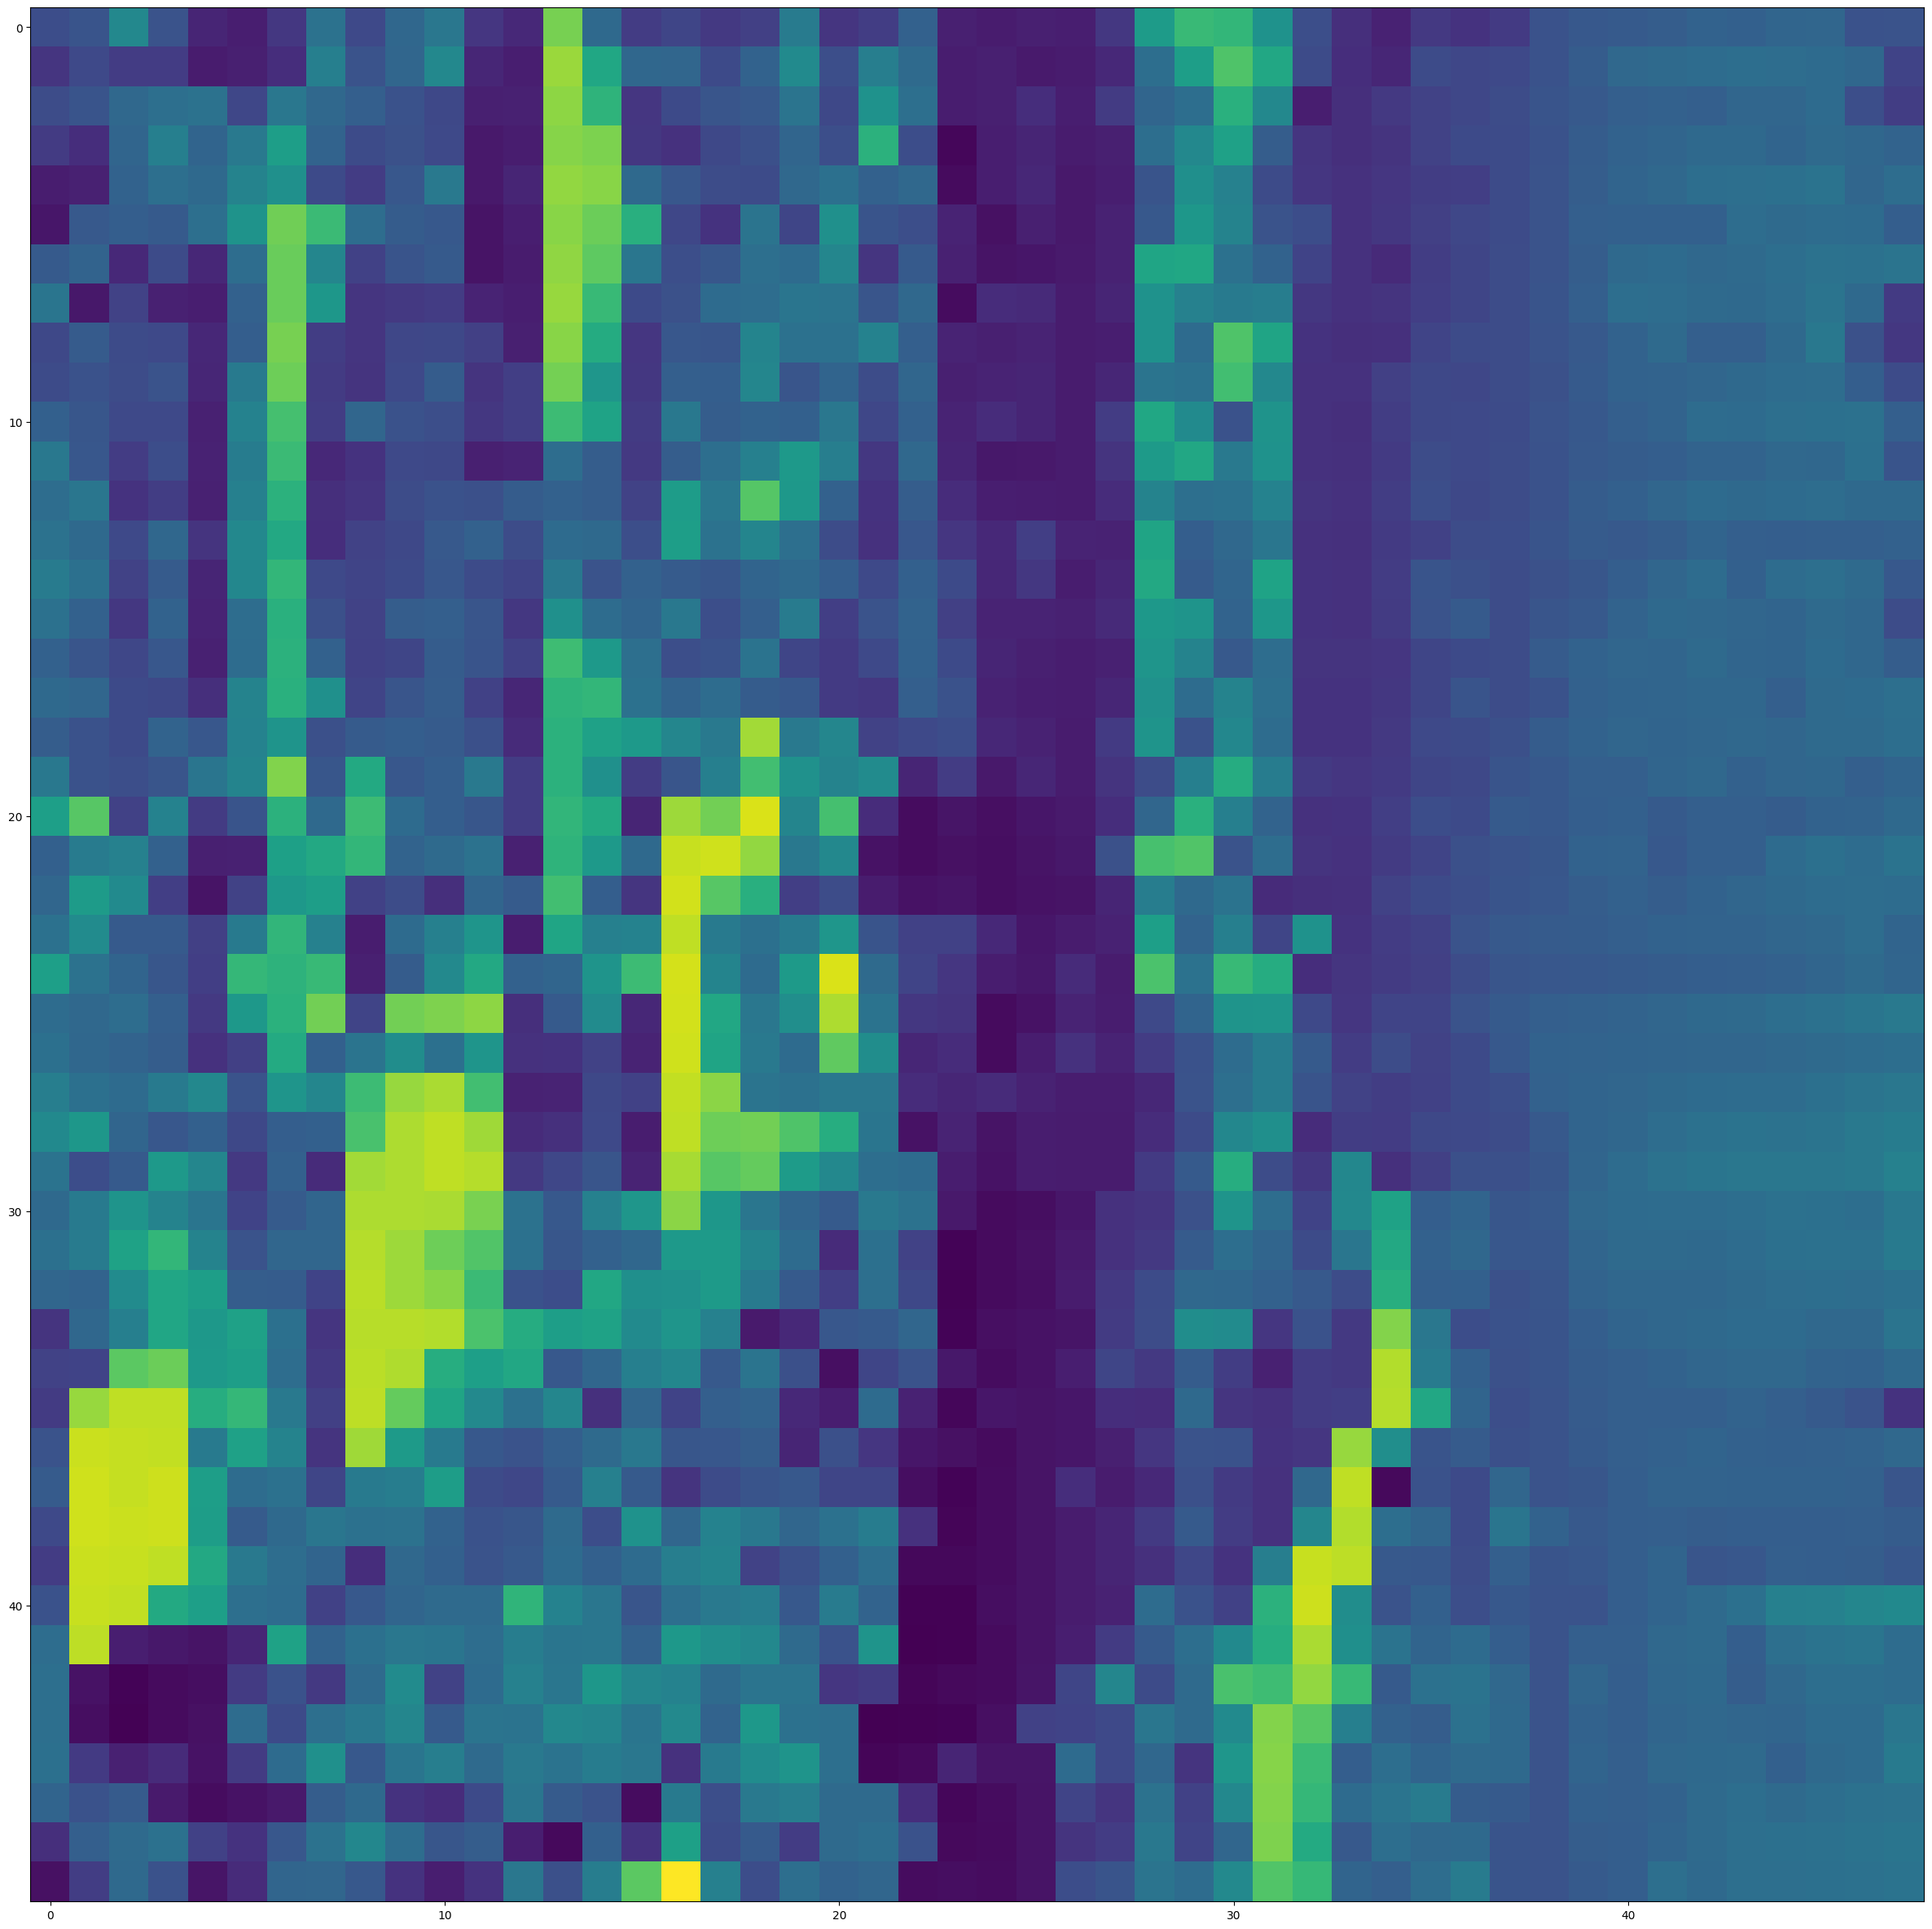

In [11]:
h,w,w = M_left_to_right.shape
index = torch.arange(w).view(1, 1, 1, w).to(M_right_to_left.device).float()    # index: 1*1*1*w
disp1 = torch.sum(M_right_to_left * index, dim=-1).view( 1, h, w) # x axis of the corresponding point
disp2 = torch.sum(M_left_to_right * index, dim=-1).view( 1, h, w)


# disp = disp.squeeze(0)
gray_scale = torch.sum(disp1,0)
gray_scale = gray_scale /disp1.shape[0]  # torch.Size([64, 112, 112]) —> torch.Size([112, 112])   从彩色图片变为黑白图片  压缩64个颜色通道维度，否则feature map太多张
gray_scale = gray_scale.data.cpu().numpy()


fig = plt.figure(figsize=(30, 50))
img_plot = plt.imshow(gray_scale)
# cv2.imwrite('heat_map.jpg', blended_img)  # 将图像保存到硬盘
plt.savefig('vis/disp.jpg', bbox_inches='tight')  # 若不加bbox_inches='tight'，保存的图片可能不完整
